# 决策树与随机森林

## 决策树

![jupyter](./class_twelve_1.png)

## 随机森林

![jupyter](./class_twelve_9.png)

# 决策树节点字段选择

## 信息熵

### 信息熵

![jupyter](./class_twelve_2.png)

### 条件熵

![jupyter](./class_twelve_3.png)

### 信息增益

![jupyter](./class_twelve_4.png)

### 信息增益率

![jupyter](./class_twelve_5.png)

## 基尼指数

### 基尼指数

![jupyter](./class_twelve_6.png)

### 条件基尼指数

![jupyter](./class_twelve_7.png)

### 基尼指数增益

![jupyter](./class_twelve_8.png)

# 模型

## 数据

### 数据清洗

In [1]:
#导入第三方模块
import pandas as pd

In [8]:
#读入数据
titanic = pd.read_csv(r"./data_class/Titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
#删除无意义变量
titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [10]:
#检查剩余字段是否含有缺失值
titanic.isnull().sum(axis=0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [11]:
#对Sex分组，用各组乘客的平均年龄填充各组中的缺失年龄
fillna_titanic = []
for sex in titanic.Sex.unique():
    update = titanic.loc[titanic.Sex == sex, ].fillna(value= {'Age':titanic.Age[titanic.Sex==sex].mean()})
    fillna_titanic.append(update)
titanic = pd.concat(fillna_titanic)

In [12]:
#使用Embarked变量的众数进行缺失值填充
titanic.fillna(value={'Embarked':titanic.Embarked.mode()[0]}, inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S


In [14]:
#将数值型的Pclass转换为类别型，否则无法对其进行哑变量处理
titanic.Pclass = titanic.Pclass.astype('category')
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S


In [15]:
#哑变量处理
dummy = pd.get_dummies(titanic[['Sex', 'Embarked', 'Pclass']])
dummy.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,0,0,1,0,0,1
4,0,1,0,0,1,0,0,1
5,0,1,0,1,0,0,0,1
6,0,1,0,0,1,1,0,0
7,0,1,0,0,1,0,0,1


In [16]:
#水平合并titanic数据集和哑变量的数据集
titanic = pd.concat([titanic, dummy], axis=1)
#删除原始的Sex、Embarked和Pclass变量
titanic.drop(['Sex', 'Embarked', 'Pclass'], axis=1, inplace=True)
titanic.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
5,0,30.726645,0,0,8.4583,0,1,0,1,0,0,0,1
6,0,54.000000,0,0,51.8625,0,1,0,0,1,1,0,0
7,0,2.000000,3,1,21.0750,0,1,0,0,1,0,0,1


### 数据拆分

In [17]:
#导入第三方包
from sklearn import model_selection

In [19]:
#取出所有自变量名称
predictors = titanic.columns[1:]
predictors

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [21]:
#将数据集拆分为训练集和测试集，测试集的比例为25%
X_train, X_test, y_train, y_test = model_selection.train_test_split(titanic[predictors], titanic.Survived, test_size=0.25, random_state=1234)


## 决策树

### 模型函数

DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, class_weight=None)  
criterion：用于指定选择节点字段的评价指标，对于分类决策树，默认为'gini'，表示才有基尼指数选择的最佳分割字段；对于回归决策树，默认为'mse'，表示使用均方误差选择节点的最佳分割字段  
splitter：用于指定节点中的分割点选择方法，默认为'best'，表示从所有的分割点中选择最佳分割点；如果指定为'random'，则表示随机选择分割点  
max_depth：用于指定决策树最大深度，默认为None，表示树的生长过程中对深度不做任何限制  
min_samples_split：用于指定根节点或中间节点能够继续分割的最小样本量，默认为2  
min_sample_leaf：用于指定叶节点的最小样本量，默认为1  
max_leaf_nodes：用于指定最大的叶节点个数，默认为None，表示对叶节点个数不做任何限制  
class_weight：用于指定因变量中类别之间的权重，默认为None，表示每个类别权重都相等；如果为balance，则表示类别权重与原始样本中类别的比例成反比；还可以通过字典传递类别之间的权重差异，其形式为(class_label:weight)

### 模型建立

In [22]:
#导入第三方模块
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [23]:
#预设各参数的不同选项值
max_depth = [2, 3, 4, 5, 6]
min_samples_split = [2, 4, 6, 8]
min_samples_leaf = [2, 4, 8, 10, 12]

In [24]:
#将各参数数值以字典形式组织起来
parameters = {'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}

In [25]:
#网格搜索法，测试不同的参数数值
grid_dtcateg = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=parameters, cv=10)


In [26]:
#模型拟合
grid_dtcateg.fit(X_train, y_train)
#返回最佳参数值
grid_dtcateg.best_params_

{'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [27]:
#导入第三方模块
from sklearn import metrics

In [28]:
#构建分类决策树
CART_Class = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, min_samples_split=2)

In [29]:
#模型拟合
decision_tree = CART_Class.fit(X_train, y_train)

### 模型的预测与评估

In [31]:
#模型在测试集上的预测
pred =CART_Class.predict(X_test)

In [32]:
#模型的准确率
print('模型在测试集的预测准确率：\n', metrics.accuracy_score(y_test, pred))

模型在测试集的预测准确率：
 0.8475336322869955


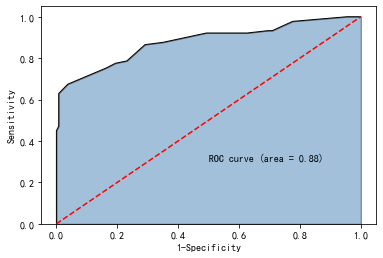

In [34]:
#ROC曲线
#导入第三方包
import matplotlib.pyplot as plt
y_score = CART_Class.predict_proba(X_test)[:, 1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
#计算AUC的值
roc_auc = metrics.auc(fpr, tpr)

#绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
#添加边际线
plt.plot(fpr, tpr, color='black', lw=1)
#添加对角线
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
#添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area = %0.2f)' %roc_auc)
#添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
#显示图形
plt.show()

In [ ]:
# 需要在电脑中安装Graphviz
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# 然后将解压文件中的bin设置到环境变量中
# 导入第三方模块
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO
# 绘制决策树
dot_data = StringIO()
export_graphviz(
    decision_tree,
    out_file=dot_data,  
    feature_names=predictors,
    class_names=['Unsurvived','Survived'],  
    # filled=True,
    rounded=True,  
    special_characters=True
)
# 决策树展现
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 

## 随机森林

### 模型函数

RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, bootstrap=True, class_weight=None)  
n_estimators：用于指定随机森林所包含的决策树个数  
criterion：用于指定每棵决策树节点的分割字段所使用的度量标准，用于分类的随机森林，默认的criterion值为'gini'；用于回归的随机森林，默认的criterion值为'mse'  
max_depth：用于指定每棵决策树的最大深度，默认不限制树的生长深度  
min_samples_split：用于指定每棵决策树根节点或中间节点能够继续分割的最小样本量，默认为2  
min_sample_leaf：用于指定每个决策树叶节点的最小样本量，默认为1  
max_leaf_nodes：用于指定每棵决策树最大的叶节点个数，默认为None，表示节点个数不做任何限制  
bootstraop：bool类型参数，是否对原始数据集进行bootstrap抽样，用于子树的构建，默认为True  
class_weight：用于指定因变量中类别之间的权重，默认为None,表示每个类别的权重都相等  

### 模型构建

In [35]:
# 导入第三方包
from sklearn import ensemble

In [36]:
#构建随机森林
RF_class = ensemble.RandomForestClassifier(n_estimators=200, random_state=1234)
#随机森林的拟合
RF_class.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=1234)

### 模型的预测与评估

In [37]:
#模型在测试集上的预测
RFclass_pred = RF_class.predict(X_test)

In [38]:
#模型的准确率
print('模型在测试集的预测准确率：\n', metrics.accuracy_score(y_test, RFclass_pred))

模型在测试集的预测准确率：
 0.852017937219731


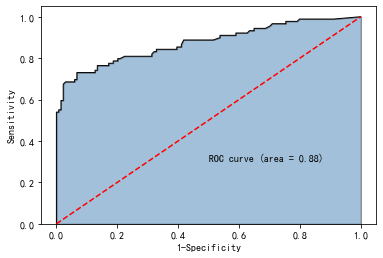

In [40]:
#绘制ROC曲线
#计算绘图数据
y_score = RF_class.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr, tpr)
#绘图
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
plt.plot(fpr, tpr, color='black', lw=1)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.text(0.5, 0.3, 'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

### 变量重要性

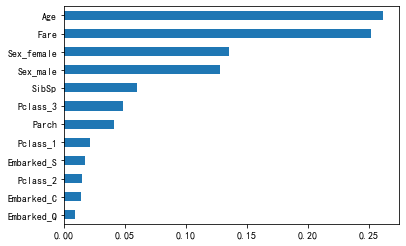

In [43]:
#变量的重要性程度值
importance = RF_class.feature_importances_
#构建行序列用于绘图
Impt_Series = pd.Series(importance, index=X_train.columns)
#对序列排序绘图
Impt_Series.sort_values(ascending=True).plot(kind='barh')
plt.show()